# Learning about Q-learning

Opskriver profitfunktion som i Klein (2021)

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit
from timeit import default_timer as timer

In [2]:
@njit
def find_index(array, item : float):
    """
    Find the index of the first occurrence of a given item in a numpy array.

        Parameters:
                array (Array): The array to search in.
                item (float): The item to search for.

        Returns:
                Tuple[int, ...]: The index of the first occurrence of `item` in `array`.
                The returned index is a tuple of integers representing the position
                of the item along each dimension of the array

        Raises:
            ValueError: If the item is not found in the array.
    """
    for idx, val in np.ndenumerate(array):
        if (abs(val - item) < 0.0000001):
            return idx[0]
    #print("ERROR: ", item, "not found in array")
    return -1

In [3]:
@njit
def demand(p1t, p2t) -> float:
    if (p1t < p2t):
        return 1 - p1t
    elif (p1t == p2t):
        return 0.5 * (1 - p1t)
    elif (p1t > p2t):
        return 0

In [4]:
@njit
def profit(p1t, p2t) -> float:
    return p1t * demand(p1t, p2t)

In [5]:
@njit('(int64, int64, int64, int64, float64, float64, float64[:,:], float64[:,:], float64[:])', fastmath=True)
def Q(p_it_idx, s_t_idx, i, t, alpha, delta, p_table, Q_table, prices) -> float: # p_table contains p and s (opponent price)
    if i == 0:
        j = 1
    else:
        j = 0
    prev_est = Q_table[p_it_idx, s_t_idx]
    s_t_next_idx = find_index(prices, p_table[j, t+1]) # index for next state (s_{t+1})
    maxed_Q = max(Q_table[:, s_t_next_idx])
    new_est = profit(p_table[i, t], p_table[j, t]) + delta * profit(p_table[i, t], p_table[j, t+1]) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

In [6]:
#@njit(parallel = True)
@njit
def set_price(i, t, p_table, Q_table, prices, epsilon) -> float:
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(prices)
    else:
        if i == 0:
            j = 1
        else:
            j = 0
        s_t_idx = find_index(prices, p_table[j, t-1]) # our state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        #print("s_t_idx ", np.where(prices == p_table[j, t-1])[0][0])
        #print("opponentprice: ", p_table[j, t-1])
        #print("maxedQ_idx: ", maxedQ_idx, "i = ", i, "Q-value: ", Q_table[maxedQ_idx, s_t_idx])
        #print("Q_table ", i, "t = ", t, ": \n", Q_table)
        return prices[maxedQ_idx]

In [7]:
@njit
def curr_prof(p_table, profits, i, t):
    if i == 0:
        j = 1
    else:
        j = 0
    profits[i, t] = profit(p_table[i,t], p_table[j,t])
    return
# i=0
# t=0
# profits = np.zeros((2,1))
# p_table = np.zeros((2,1))
# p_table[0,0]=1/3
# p_table[1,0]=1/3
# curr_prof(p_table, profits, i, t)
# print(profits)

In [8]:
#@njit
@njit('(float64, float64, int64)', parallel=True, fastmath=True)
def bertrand_simulation(alpha, delta, T):

    # array of possible prices firms can choose (in this case k=6)
    prices = np.linspace(0, 1, 7)

    i = 0
    j = 1
    
    t = 0
    # calculate the decay parameter theta
    theta = -(1/1000000)**(1/T) + 1
    epsilon = (1 - theta)**t

    p = len(prices)
    Q_table1 = np.zeros((p, p)) # |P| x |S| matrix
    Q_table2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    profitabilities1 = []
    profitabilities2 = []

    p_table[i, t] = np.random.choice(prices) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(prices) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    while t < T:

        if i == 0: # update firm 0
            # exploration module
            p_it_idx = find_index(prices, p_table[i, t-2])
            #print("p_it_idx: ", p_it_idx)
            s_t_idx =  find_index(prices, p_table[j, t-2])
            Q_table1[p_it_idx, s_t_idx] = Q(p_it_idx, s_t_idx, i, t-2, alpha, delta, p_table, Q_table1, prices)

            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table1, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]

            # write profits for firm 0 and 1
            curr_prof(p_table, profits, 0, t)
            curr_prof(p_table, profits, 1, t)

            #compute avg profitability of last 1000 runs
            if t % 50000 == 0:
                profitability = np.sum(profits[i, (t-1000):t])/1000
                #print("profitability firm 0", profitability)
                profitabilities1.append(profitability)
        else: # update firm 1
            # exploration module
            p_it_idx = find_index(prices, p_table[i, t-2])
            s_t_idx =  find_index(prices, p_table[j, t-2])
            Q_table2[p_it_idx, s_t_idx] = Q(p_it_idx, s_t_idx, i, t-2, alpha, delta, p_table, Q_table2, prices)

            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table2, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]

            # write profits for firm 1 and 0
            curr_prof(p_table, profits, 0, t)
            curr_prof(p_table, profits, 1, t)
            if t % 50000 == 1:    
                profitability = np.sum(profits[i, (t-1000):t])/1000
                #print("profitability firm 1", profitability)
                profitabilities2.append(profitability)

        # calculate new epsilon using decay parameter
        epsilon = (1 - theta)**t

        tmp = i
        i = j
        j = tmp
        t += 1
    return p_table, profitabilities1, profitabilities2

In [9]:

"""alpha, delta = 0.3, 0.95  # values from Klein(2021)
T = 500000
N = 1
#fig, axs = plt.subplots(N)
#fig.suptitle("Profitabilities in 10 different runs (500000 runs each)")
#fig.set_figheight(12)
#fig.set_figwidth(12)
joint_profitability = np.zeros(int(T/50000 - 1))

for n in range(0, N):
    p_table, profitabilities1, profitabilities2 = bertrand_simulation(alpha, delta, T)
    """

'alpha, delta = 0.3, 0.95  # values from Klein(2021)\nT = 500000\nN = 1\n#fig, axs = plt.subplots(N)\n#fig.suptitle("Profitabilities in 10 different runs (500000 runs each)")\n#fig.set_figheight(12)\n#fig.set_figwidth(12)\njoint_profitability = np.zeros(int(T/50000 - 1))\n\nfor n in range(0, N):\n    p_table, profitabilities1, profitabilities2 = bertrand_simulation(alpha, delta, T)\n    '

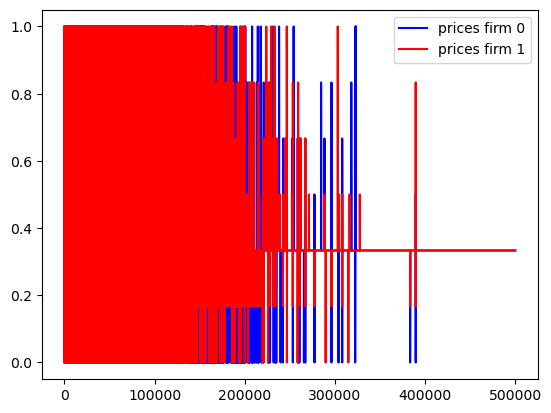

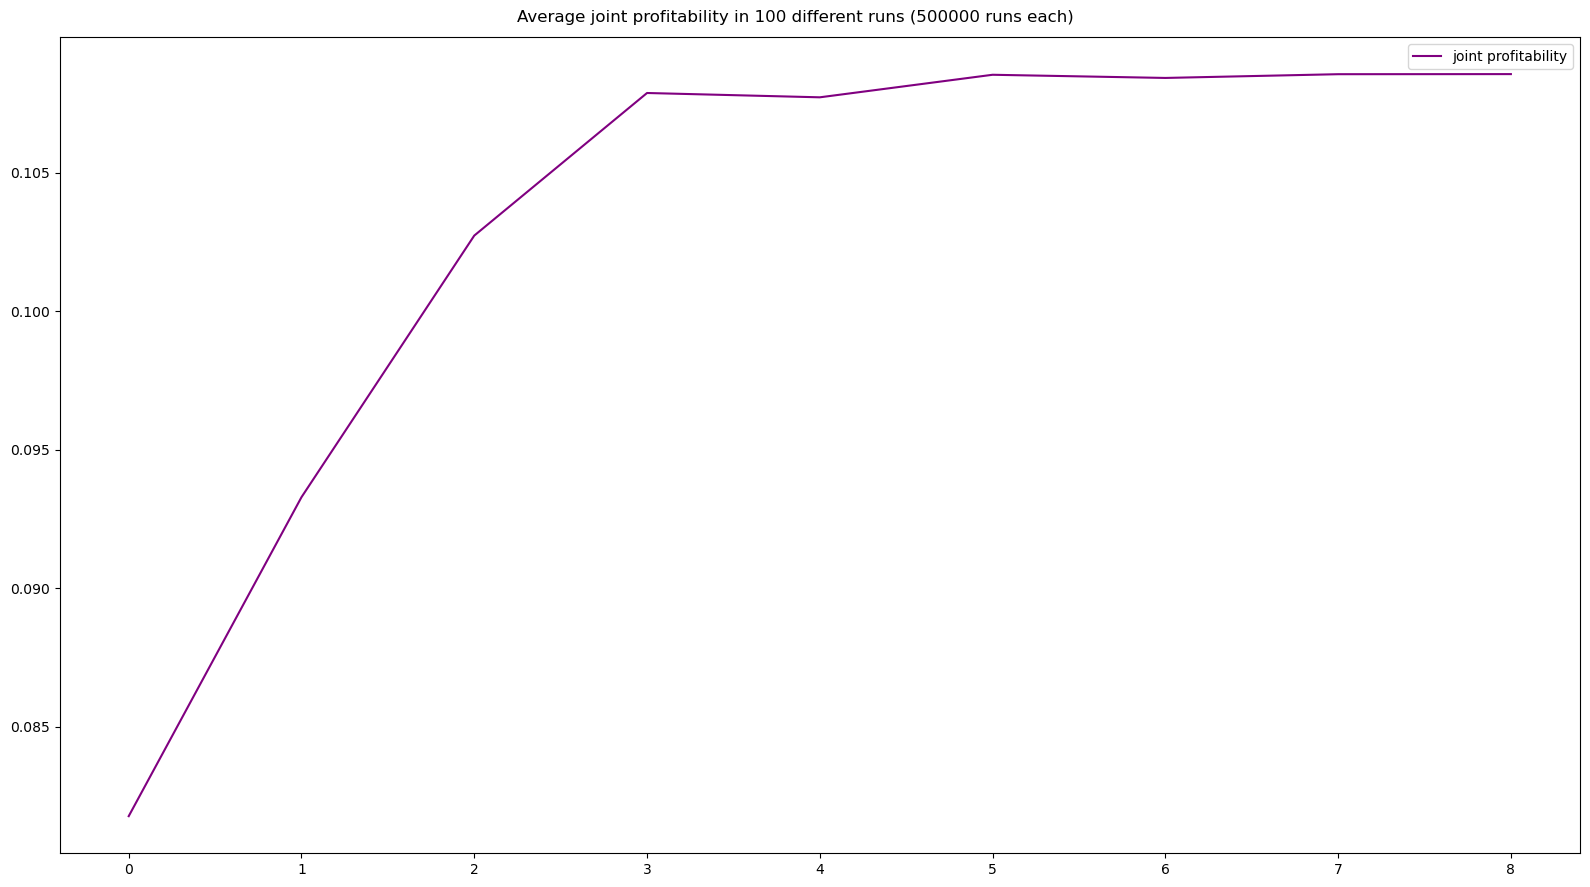

time spent: 12.35101258798386 s


In [10]:
# set parameters
#np.random.seed(42) # optionally use a fixed seed
start = timer()

alpha, delta = 0.3, 0.95  # values from Klein(2021)
T = 500000
N = 100

joint_profitability = np.zeros(int(T/50000 - 1))

for n in range(0, N):
    p_table, profitabilities1, profitabilities2 = bertrand_simulation(alpha, delta, T)
    
    summed_profitabilities = np.sum([profitabilities1, profitabilities2], axis=0)
    joint_profitability = np.sum([joint_profitability, summed_profitabilities/2], axis=0)
    
    if n == N-1:
        plt.plot(range(0,T), p_table[0,:], color='blue', label = 'prices firm 0')
        plt.plot(range(0,T), p_table[1,:], color='red', label = 'prices firm 1')
        plt.legend()

joint_profitability = joint_profitability/N

fig, axs = plt.subplots(1)
fig.suptitle("Average joint profitability in 100 different runs (500000 runs each)")
fig.set_figheight(9)
fig.set_figwidth(16)
axs.plot(range(len(joint_profitability)), joint_profitability, color="purple", label = "joint profitability")

fig.tight_layout()
plt.legend()
plt.show()
end = timer()
print("time spent:", end - start, "s")